In [130]:
import os
import cv2 as cv
import nibabel as nib
import numpy as np
import concurrent.futures
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score, precision_score, confusion_matrix
from tqdm import tqdm
from PIL import Image
import logging
import torch
import torchvision.transforms as transforms
# import torch_xla
# import torch_xla.core.xla_model as xm

print

In [131]:
def calculate_metrics(true_mask, pred_mask):
        # Confusion Matrix
        cm = confusion_matrix(true_mask, pred_mask, labels=[0, 1])
        # True Negative Rate (Specificity)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        # Dice coefficient
        dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0.0
        # Sensitivity (Recall)
        sensitivity = recall_score(true_mask, pred_mask, labels=[0, 1], average="binary")
        # Precision
        precision = precision_score(true_mask, pred_mask, labels=[0, 1], average="binary")
        # Accuracy
        acc_value = accuracy_score(true_mask, pred_mask)
        # F1 Score
        f1_value = f1_score(true_mask, pred_mask, labels=[0, 1], average="binary")
        # Jaccard Score
        jacc_value = jaccard_score(true_mask, pred_mask, labels=[0, 1], average="binary")

        return specificity, dice, sensitivity, precision, acc_value, f1_value, jacc_value

In [132]:
images=[]
true_masks=[]
pred_masks=[]

In [133]:
image_paths=os.listdir("../3d images/eval/data")
true_mask_paths=os.listdir("../3d images/eval/label")
print(image_paths)
print(true_mask_paths)
for image_path,mask_path in zip(image_paths,true_mask_paths):

    image=cv.imread(os.path.join("../3d images/eval/data",image_path),cv.IMREAD_GRAYSCALE)
    mask=cv.imread(os.path.join("../3d images/eval/label",mask_path),cv.IMREAD_GRAYSCALE)
    images.append(image)
    true_masks.append(mask)


['data_patch_199712.png', 'data_patch_199713.png', 'data_patch_199714.png', 'data_patch_199715.png', 'data_patch_199716.png', 'data_patch_199717.png', 'data_patch_199718.png', 'data_patch_199719.png', 'data_patch_199720.png', 'data_patch_199721.png']
['label_patch_199712.png', 'label_patch_199713.png', 'label_patch_199714.png', 'label_patch_199715.png', 'label_patch_199716.png', 'label_patch_199717.png', 'label_patch_199718.png', 'label_patch_199719.png', 'label_patch_199720.png', 'label_patch_199721.png']


In [134]:
def single_image_inference(image, model, device):
   
    transform = transforms.Compose([
         transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
   
    img = transform(image).float().to(device)
    img = img.unsqueeze(0)

    with torch.no_grad():
        pred_mask = model(img)

        pred_mask = pred_mask.squeeze(0).cpu().permute(1, 2, 0).squeeze(-1)
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        return pred_mask.numpy()

In [135]:
from unet import UNet


device = torch.device('cpu')
# Assuming UNet is your model class
model = UNet(in_channels=1, num_classes=1).to(device)
# Load the model weights onto the CPU
model.load_state_dict(torch.load("../models/Single_SpineSegmentationv7.pth", map_location=device))
model.eval()
for image in images:
  pred_mask=single_image_inference(image, model, device)
  pred_masks.append(pred_mask)




In [138]:
print(pred_masks[5].shape)



(128, 128)
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ...   0. 255. 255.]
 [255. 255. 255. ...   0.   0. 255.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [141]:
import numpy as np
img=Image.fromarray((pred_masks[5]*255).astype(np.uint8))

img.save('test.png')

In [59]:
print(np.unique(true_masks[0]))

[  0 255]


C:\Users\hp\AppData\Local\Temp\ipykernel_1812\2697818220.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)  # Adjust the subplot layout


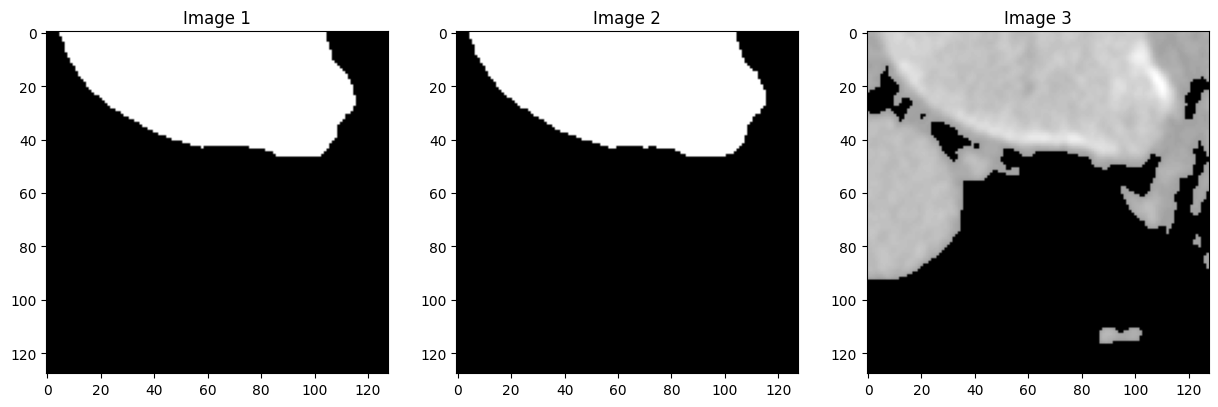

In [125]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 5))  # Adjust the figsize as needed
plt.axis('off')

plt.subplot(1, 3, 1)  # Adjust the subplot layout
plt.imshow(pred_masks[1], cmap='gray')  # Assuming grayscale images
plt.title('Image 1')

plt.subplot(1, 3, 2)
plt.imshow(true_masks[1], cmap='gray')  # Assuming grayscale images
plt.title('Image 2')

plt.subplot(1, 3, 3)
plt.imshow(images[1], cmap='gray')  # Assuming grayscale images
plt.title('Image 3')

plt.show()



In [61]:
def evaluate_metrics():
        print("calculating matrices ...............")
        specificity_scores = []
        dice_scores = []
        sensitivity_scores = []
        precision_scores = []
        f1_scores = []
        jacc_scores = []
        accuracy_scores = []

        for true_mask, pred_mask in tqdm(zip(true_masks,pred_masks)):
            # pred_mask = pred_mask / 255.0
            # pred_mask = (pred_mask > 0.5).astype(np.int32)
            pred_mask = pred_mask.flatten()

            true_mask = true_mask / 255.0
            true_mask = (true_mask > 0.5).astype(np.int32)
            true_mask = true_mask.flatten()

            specificity, dice, sensitivity, precision, acc_value, f1_value, jacc_value = calculate_metrics(
                true_mask, pred_mask)

            sensitivity_scores.append(sensitivity)
            dice_scores.append(dice)
            specificity_scores.append(specificity)
            precision_scores.append(precision)
            accuracy_scores.append(acc_value)
            f1_scores.append(f1_value)
            jacc_scores.append(jacc_value)

        # Calculate mean scores
        mean_sensitivity = np.mean(sensitivity_scores)
        mean_dice = np.mean(dice_scores)
        mean_specificity = np.mean(specificity_scores)
        mean_precision = np.mean(precision_scores)
        mean_accuracy = np.mean(accuracy_scores)
        mean_f1 = np.mean(f1_scores)
        mean_jacc = np.mean(jacc_scores)

        # Log scores
        logging.basicConfig(filename='score.log', level=logging.INFO)
        logging.info(f'Mean Sensitivity: {mean_sensitivity}')
        logging.info(f'Mean Dice: {mean_dice}')
        logging.info(f'Mean Specificity: {mean_specificity}')
        logging.info(f'Mean Precision: {mean_precision}')
        logging.info(f'Mean Accuracy: {mean_accuracy}')
        logging.info(f'Mean F1: {mean_f1}')
        logging.info(f'Mean Jaccard: {mean_jacc}')

        # Optionally, you can also log the individual arrays
        logging.info(f'Sensitivity Scores: {sensitivity_scores}')
        logging.info(f'Dice Scores: {dice_scores}')
        logging.info(f'Specificity Scores: {specificity_scores}')
        logging.info(f'Precision Scores: {precision_scores}')
        logging.info(f'Accuracy Scores: {accuracy_scores}')
        logging.info(f'F1 Scores: {f1_scores}')
        logging.info(f'Jaccard Scores: {jacc_scores}')

In [62]:
evaluate_metrics()

calculating matrices ...............


10it [00:00, 44.46it/s]


TypeError: Cannot handle this data type: (1, 1, 1), <f4